# Compare abstract embedding vs. full text paper mean chunk embedding

In [4]:
from rolling.pdf import list_pdfs_processed
pdfs = list_pdfs_processed()
len(pdfs), pdfs[:3]

(999,
 ['./arxiv_downloads_processed\\0812.0743v2.A_Novel_Clustering_Algorithm_Based_on_Quantum_Games.pkl',
  './arxiv_downloads_processed\\1103.4487v1.Handwritten_Digit_Recognition_with_a_Committee_of_Deep_Neural_Nets_on_GPUs.pkl',
  './arxiv_downloads_processed\\1106.4509v1.Machine_Learning_Markets.pkl'])

In [5]:
from rolling.paper import Paper, load_paper
papers:list[Paper] = [load_paper(file) for file in pdfs]

In [6]:
papers[0].text_segment_embeddings.shape

(370, 768)

In [11]:
def get_paper_id_by_filename(pdf):
    id = pdf.split('\\')[1]
    id = id.split('.')[0:2]
    id[1] = id[1].split('v')[0]
    return '.'.join(id)

get_paper_id_by_filename(pdfs[0])

'0812.0743'

In [7]:
def get_paper_embedding_mean(paper:Paper):
    return paper.text_segment_embeddings.mean(axis=0)

get_paper_embedding_mean(papers[0]).shape

(768,)

---
# check to see how different the embeddings actually are

In [21]:
from elasticsearch import Elasticsearch
client = Elasticsearch("http://localhost:9200/", api_key="a1VxLUZaWUJ6Q1VRYXlSWTJSX2U6RWx3X0xQbXZURnlsNGU5UmNFeWZhZw==") # localhost

In [22]:
def fetch_paper(id):
    return client.get(
        index="arxiv",
        id=id,
    )

In [23]:
embeddings = []
for file_path, paper in zip(pdfs, papers):
    try:
        emb1 = get_paper_embedding_mean(paper)

        paper_id = get_paper_id_by_filename(file_path)
        paper = fetch_paper(paper_id)
        emb2 = paper['_source']['embedding']

        embeddings.append((emb1, emb2))
    except:
        print(f'{file_path} not found')
        embeddings.append((None,None))

./arxiv_downloads_processed\2504.03309v1.Roto_Translation_Invariant_Metrics_on_Position_Orientation_Space.pkl not found
./arxiv_downloads_processed\2504.03312v1.Evaluating_Compact_LLMs_for_Zero_Shot_Iberian_Language_Tasks_on_End_User_Devices.pkl not found
./arxiv_downloads_processed\2504.03313v1.Steerable_Anatomical_Shape_Synthesis_with_Implicit_Neural_Representations.pkl not found
./arxiv_downloads_processed\2504.03315v1.Detecting_underdetermination_in_parameterized_quantum_circuits.pkl not found
./arxiv_downloads_processed\2504.03318v1.Adaptive_Classification_of_Interval_Valued_Time_Series.pkl not found
./arxiv_downloads_processed\2504.03321v1.Adaptive_sparse_variational_approximations_for_Gaussian_process_regression.pkl not found
./arxiv_downloads_processed\2504.03322v1.Block_Toeplitz_Sparse_Precision_Matrix_Estimation_for_Large_Scale_Interval_Valued_Time_Series_Forecasting.pkl not found
./arxiv_downloads_processed\2504.03327v1.Optimal_Embedding_Guided_Negative_Sample_Generation_for

In [24]:
from rolling.embedding import get_similarity
similarities = [
    get_similarity(emb1, emb2)
    for emb1, emb2 in embeddings
    if emb1 is not None
]

import numpy as np
similarities = np.array(similarities)

In [25]:
similarities.shape

(897,)

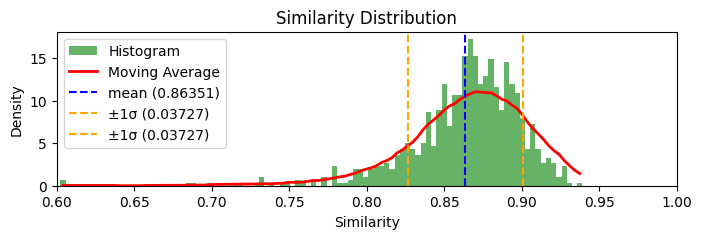

In [27]:
import numpy as np
import matplotlib.pyplot as plt

mean = np.mean(similarities)
std_dev = np.std(similarities)

plt.figure(figsize=(8, 2))
count, bins, _ = plt.hist(similarities, bins=100, density=True, alpha=0.6, color='g', label='Histogram')

window_size = 20
moving_avg = np.convolve(count, np.ones(window_size)/window_size, mode='same')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, moving_avg, color='r', label='Moving Average', linewidth=2)

plt.axvline(x=mean, color='b', linestyle='--', label=f'mean ({mean:.5f})')
plt.axvline(x=mean - std_dev, color='orange', linestyle='--', label=f'±1σ ({std_dev:.5f})')
plt.axvline(x=mean + std_dev, color='orange', linestyle='--', label=f'±1σ ({std_dev:.5f})')

plt.xlim(0.6, 1.0)
plt.xlabel('Similarity')
plt.ylabel('Density')
plt.title('Similarity Distribution')
plt.legend()
plt.show()